## Golden wind in r/WallStreetBets
### Topic Modeling Analysis

* r/WallStreetBets Research Project Phase 3
* Team 4
* Anqi Fang, Jiashuo Sun, Raymond Su

**This is a note book for part 5 of our analysis - Topic Modeling. We will be using word cloud and interactive visualization to show the result.**


In [ ]:
!pip install gensim
!pip install graphlab
!pip install pyLDAvis

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import string
from collections import Counter
from collections import defaultdict
import gensim
from gensim.models.phrases import Phrases
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pickle
# from pyLDAvis import graphlab
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

pyLDAvis.enable_notebook()

In [2]:
df = pd.read_csv("./cleaned_submissions.csv")

In [3]:
df = df[['author','id','num_comments','score','title','upvote_ratio','date','cleaned_text','tokened_text']]

In [4]:
# Remove Stop_words and add-on stop words
from wordcloud import WordCloud
add_stop_words = ['nbsp', 'also', 'really', 'ive', 'even', 'jon', 'lot', 'could', 'many', 'dont', 'like', 
                  'still', 'even', 'get', 'got', 'im', 'thats', 'youre', 'know', 'make', 'fucking', 'going', 'right']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

In [5]:
stop_words = list(set(stop_words))
#create word cloudn object
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

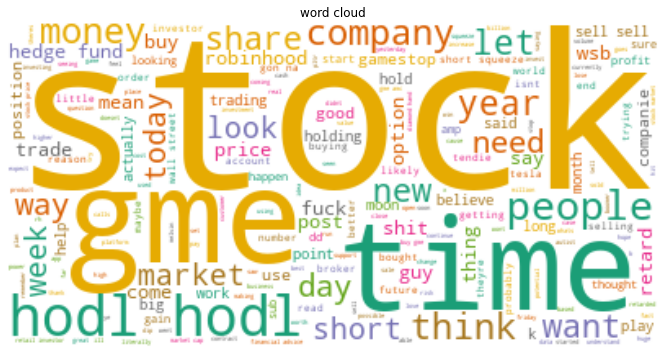

In [6]:
#Print word cloud
clean_text = df.cleaned_text.tolist()
clean_text = [x for x in clean_text if x is not np.nan]

joinstr = " ".join([str(text) for text in clean_text])
wc.generate(joinstr)

plt.rcParams['figure.figsize'] = [16, 6]
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("word cloud")
plt.show()

### LDA - Topic Modeling

* LDA’s approach to topic modeling is it considers each document as a collection of topics in a certain proportion. And each topic as a collection of keywords, again, in a certain proportion.



In [7]:
cv = CountVectorizer(ngram_range=(1,1),max_df=.30, min_df=.0001,stop_words=stop_words)
cv_vecs = cv.fit_transform(df.tokened_text).transpose()

In [8]:
from gensim import corpora, matutils, models

cv_corpus = matutils.Sparse2Corpus(cv_vecs)
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

# change from corpus into corpora Dictionary object type
id2word = corpora.Dictionary.from_corpus(cv_corpus, id2word=id2word)

#### Selecting number of topic - UMass Coherence
* In order to find out how many topics we should analysis using LDA, we will be using the coherence score to do elbow method to find out the optimal number of clusters. 
* We used UMass coherence score instead of the CV score, because UMass calculates how often two words, w1 and w2 appear together in the corpus. Thus, the greater the number, the better the coherence score.
* Reference: https://www.baeldung.com/cs/topic-modeling-coherence-score#:~:text=It%20calculates%20how%20often%20two,the%20better%20is%20coherence%20score.

In [9]:
#Define function for computing the Umass coherences
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

coherence_values = []
model_list = []

def compute_coherence_values (start, limit, step):

    i = start
    for topic_num in range(start, limit, step):
        model_list.append(topic_num)
        lda = LdaModel(corpus=cv_corpus, id2word=id2word, num_topics=topic_num, passes=10)
        cm = CoherenceModel(model=lda, corpus=cv_corpus, coherence='u_mass')
        coherence = cm.get_coherence() 
        coherence_values.append(coherence)


In [10]:
compute_coherence_values(1, 30, 3)

In [11]:
coherence_values

[-1.6155606011415058,
 -1.9650755937237754,
 -2.1811687644983007,
 -2.368531076078729,
 -2.82946185063287,
 -3.092442893409592,
 -4.031765277637211,
 -3.2169596971129195,
 -3.795244928769519,
 -3.5449712038827554]

In [12]:
model_list

[1, 4, 7, 10, 13, 16, 19, 22, 25, 28]

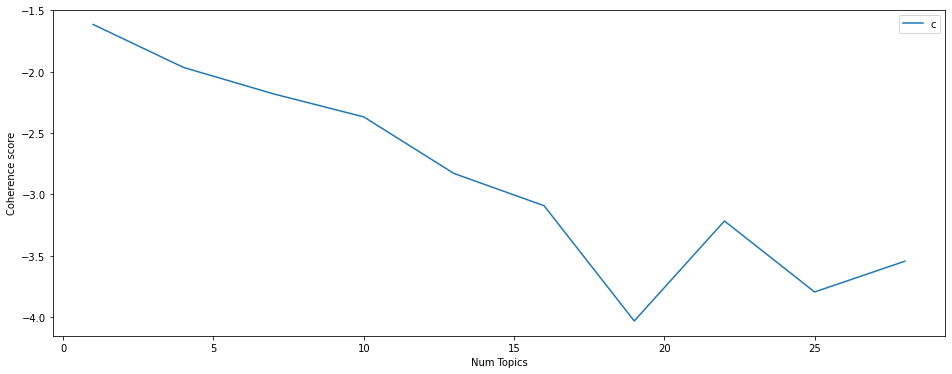

In [13]:
import matplotlib.pyplot as plt

x = range(1, 30, 3)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

* According to the UMASS coherence measurements, the coherence of the topics globally decreases when K increases. Despite that We do see a significant raise of score after 19. As for now, we will only select the number of topic within 30 for efficiency. 
* The first bump on the graph is at around 4. However, 4 is a relatively small number that might not produce very interpretable outcome. We will choose 13 for now as it is the second bump on the graph for the purpose of analysis.


#### Result of topic modeling

In [14]:
# modify the number of topics as 13
lda = LdaModel(corpus=cv_corpus, id2word=id2word, num_topics=13, passes=10)
#lda.print_topics()

In [15]:
import pyLDAvis.gensim_models as gensimvis

viz = gensimvis.prepare(topic_model=lda, corpus=cv_corpus, dictionary=id2word, mds='mmds')
pyLDAvis.display(viz)

C:\Users\Raymond\AppData\Roaming\Python\Python38\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


**Here are the top 13 topics for the learned topics from LDA**:

* Topic #1, 15.4% of tokens:
  
  The words are mainly some of the action terms, not necessary financial terms tho, that was used during the GME incident.

* Topic #2, 13.6% of tokens:

  There are some overlap on topic #1 and #2, and we are seeing "GME" in topic 2 as well. The differnces is that topic #2 contains more technical financial terms, eg "short", "squeeze", "option".

* Topic #3, 13.5% of tokens:

  Topic #3 has many terms regarding the entire financial market and the technical industry. Some of the terms about future are also included. Eg. "Tesla", "million", "Energy", "potential".

* Topic #4, 11.3% of tokens:
  
  Topic #4 might need to be included in the stop_word list if we have the chance to re-do the analysis since many of are bad words. On the other hand, we also interpret that topic #4 is all about the negative emotion and frustration that people have.

* Topic #5, 10.1% of tokens:
  
  Topic #5 mostly contains the technical terms in finanical industry and stock trading. 

* Topic #6, 6.7% of tokens:
  
  Topic #6 has many terms related to the popular stock trading platform, fintech topic, and hedge funds. Eg. "Rabinhood", "Citadel". Interestingly, despite topic #6 also mentioned GME and GameStop, the position of cluster is not very closed to topic #1 and #2, which also have. Thus it might be implying some different things, and if we observe more, we also saw "manipulation", "risk", "price". 

  

The rest of the topics are relatively less significant for intterpretation. Some of them are labeled in the same cluster probably because they are not related to any other topics. 
